# **Hackman Challenge - Part 1: Comprehensive Data & Cleaning Report**

**Objective:** To perform a rigorous analysis of the provided `corpus.txt`file to inform our model-building strategy.

**Goals for this Notebook:**
1.  **Cleanse Data:** Identify and remove all noise, invalid words, and duplicates from the source files.
2.  **Generate Clean Artifacts:** Produce new, clean files (`corpus_clean_unique.txt` and `test_clean_unique.txt`) to be used as the "source of truth" for all subsequent ML modeling.
3.  **Deep-Dive Analysis:** Perform advanced contextual analysis (Positional, N-gram, Heatmaps) to justify our hybrid HMM/RL model design.
5.  **Export All Findings:** Save all plots and data tables as new files for our final report.



In [ ]:
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import json

# Set a professional plotting style for the review
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams['figure.figsize'] = (16, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

print("Libraries imported. EDA environment is ready.")

Libraries imported. EDA environment is ready.


In [ ]:
def load_clean_and_save(filename, output_filename):
    """
    Loads a word list, performs rigorous cleaning, reports stats, and saves the clean list.

    CLEANING LOGIC:
    1. Read all lines.
    2. Convert to lowercase.
    3. TRANSFORM: Remove *all* non-alphabetic characters (spaces, numbers, punctuation).
       - "au revoir" -> "aurevoir"
       - "it's" -> "its"
       - "data1base" -> "database"
    4. FILTER: Remove any resulting empty strings (e.g., "!" or "123" become "").
    5. DE-DUPLICATE: Get the unique set of cleaned words.
    """
    print(f"--- Processing: {filename} ---")
    try:
        with open(filename, 'r') as f:
            words = f.read().splitlines()
    except FileNotFoundError:
        print(f"ERROR: '{filename}' not found. Please upload it to Colab.")
        return [], None

    raw_count = len(words)
    print(f"1. Total raw lines loaded: {raw_count:,}")

    # Step 2: Convert to lowercase
    lower_words = [w.lower() for w in words]

    # Step 3: TRANSFORM (This is the new, better logic)
    # We use a regex, re.sub(r'[^a-z]', '', w), which substitutes
    # anything that is NOT a lowercase letter with an empty string.
    transformed_words = [re.sub(r'[^a-z]', '', w) for w in lower_words]

    # Step 4: FILTER (Remove empty strings that resulted from the transform)
    cleaned_words = [w for w in transformed_words if w]
    non_alpha_or_empty_count = raw_count - len(cleaned_words)
    print(f"2. Removed {non_alpha_or_empty_count:,} invalid lines (noise, numbers, or pure punctuation).")

    # Step 5: DE-DUPLICATE
    unique_alpha_words = sorted(list(set(cleaned_words)))
    duplicate_count = len(cleaned_words) - len(unique_alpha_words)
    final_count = len(unique_alpha_words)
    print(f"3. Removed {duplicate_count:,} duplicate words (e.g., 'it's' and 'its' both became 'its').")

    print(f"Done. Final clean, unique word count: {final_count:,}")

    # Step 6: Save the new, clean file artifact
    try:
        with open(output_filename, 'w') as f:
            for word in unique_alpha_words:
                f.write(f"{word}\n")
        print(f"==> ARTIFACT CREATED: Saved {final_count} words to '{output_filename}'\n")
    except Exception as e:
        print(f"Error saving file '{output_filename}': {e}\n")



    # Create a stats dictionary for the summary table
    stats = {
        "File": filename,
        "Raw Lines": raw_count,
        "Removed (Noise/Invalid)": non_alpha_or_empty_count,
        "Removed (Duplicates)": duplicate_count,
        "Final Clean Count": final_count
    }

    return unique_alpha_words, stats

In [ ]:
# --- Run the Cleaning Process & Create Files ---
# This cell CALLS the function defined in the cell above.
# This is the cell that will produce all the print output!

# Make sure your Google Drive is mounted and these paths are correct!
corpus_file_path = '/content/corpus.txt'
test_file_path = '/content/test.txt'

corpus_clean, corpus_stats = load_clean_and_save(corpus_file_path, 'corpus_clean_unique.txt')
test_clean, test_stats = load_clean_and_save(test_file_path, 'test_clean_unique.txt')

# Create a summary DataFrame for a nice table
if corpus_stats and test_stats:
    summary_df = pd.DataFrame([corpus_stats, test_stats])

    print("--- Cleaning Summary ---")
    print(summary_df.to_markdown(index=False, numalign="right", stralign="right"))
else:
    print("Could not generate summary table. Did files load?")

--- Processing: /content/corpus.txt ---
1. Total raw lines loaded: 50,000
2. Removed 0 invalid lines (noise, numbers, or pure punctuation).
3. Removed 602 duplicate words (e.g., 'it's' and 'its' both became 'its').
Done. Final clean, unique word count: 49,398
==> ARTIFACT CREATED: Saved 49398 words to 'corpus_clean_unique.txt'

--- Processing: /content/test.txt ---
1. Total raw lines loaded: 2,000
2. Removed 0 invalid lines (noise, numbers, or pure punctuation).
3. Removed 0 duplicate words (e.g., 'it's' and 'its' both became 'its').
Done. Final clean, unique word count: 2,000
==> ARTIFACT CREATED: Saved 2000 words to 'test_clean_unique.txt'

--- Cleaning Summary ---
|                File |   Raw Lines |   Removed (Noise/Invalid) |   Removed (Duplicates) |   Final Clean Count |
|--------------------:|------------:|--------------------------:|-----------------------:|--------------------:|
| /content/corpus.txt |       50000 |                         0 |                    602 |        

In [ ]:
# Create a directory to store all our EDA findings
output_dir = "eda_artifacts"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print(f"All generated EDA files will be saved in the '{output_dir}/' folder.")

All generated EDA files will be saved in the 'eda_artifacts/' folder.


## Analysis 1: Word Length Frequency

**Objective:** To understand the distribution of word lengths in our clean corpus.


--- Analysis 1: Word Length Frequency (corpus_clean_unique.txt) ---


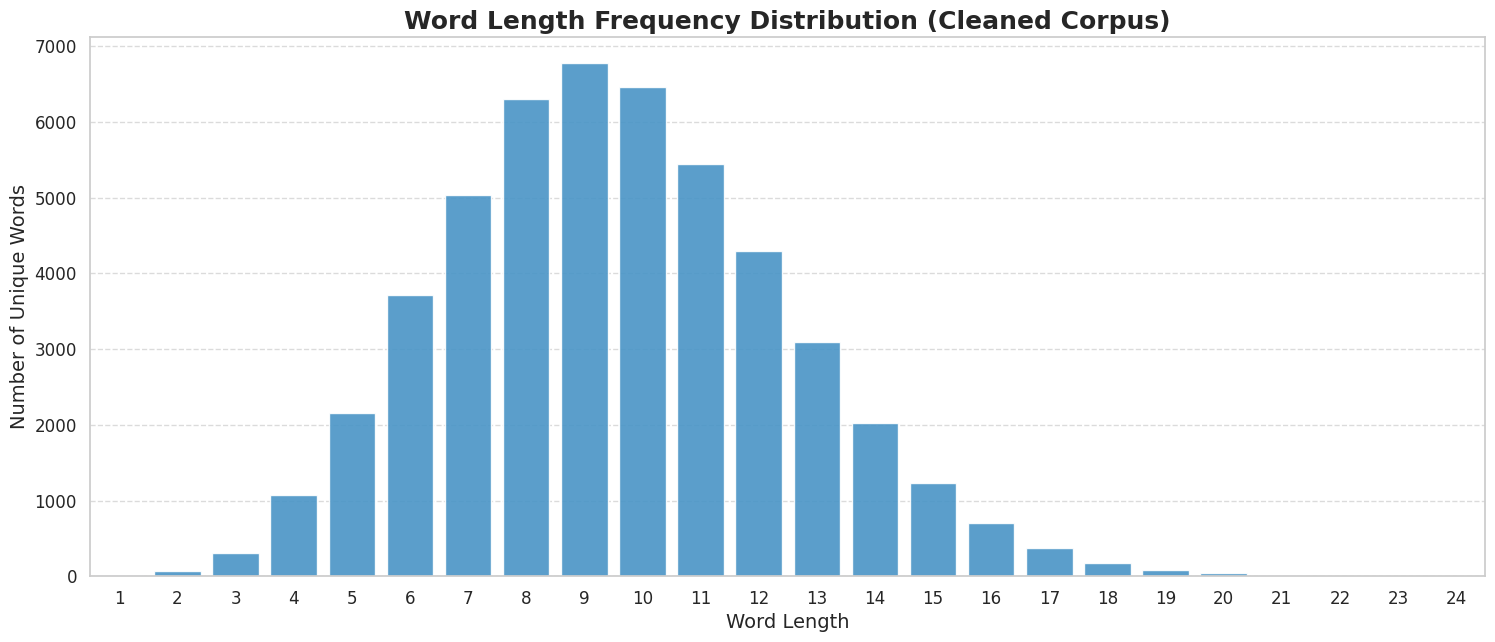

Plot saved to: eda_artifacts/plot_word_length_distribution.png
Data saved to: eda_artifacts/data_word_length_distribution.csv

--- Analysis Takeaway ---
Total Unique Words: 49,398
Most Common Word Length: 9
Observation: The distribution is heavily centered. Most words are between 4 and 12 letters.
This confirms that filtering by word length is a powerful first step for our model.


In [ ]:
print("--- Analysis 1: Word Length Frequency (corpus_clean_unique.txt) ---")
if not corpus_clean:
    print("Cannot perform analysis: 'corpus_clean' list is empty. Did Cell 3 run correctly?")
else:
    # --- Prepare Data ---
    len_counter = Counter([len(w) for w in corpus_clean])
    len_df = pd.DataFrame(len_counter.items(), columns=['Word Length', 'Frequency'])
    len_df = len_df.sort_values(by='Word Length')

    # --- Plot ---
    plt.figure(figsize=(18, 7))
    sns.barplot(data=len_df, x='Word Length', y='Frequency', color='#3498db', alpha=0.9)

    plt.title('Word Length Frequency Distribution (Cleaned Corpus)', fontsize=18, fontweight='bold')
    plt.xlabel('Word Length')
    plt.ylabel('Number of Unique Words')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Save Artifacts ---
    plot_filename = os.path.join(output_dir, 'plot_word_length_distribution.png')
    plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
    plt.show()

    csv_filename = os.path.join(output_dir, 'data_word_length_distribution.csv')
    len_df.to_csv(csv_filename, index=False)

    print(f"Plot saved to: {plot_filename}")
    print(f"Data saved to: {csv_filename}")
    print("\n--- Analysis Takeaway ---")
    print(f"Total Unique Words: {len(corpus_clean):,}")
    print(f"Most Common Word Length: {len_df.loc[len_df['Frequency'].idxmax()]['Word Length']}")
    print("Observation: The distribution is heavily centered. Most words are between 4 and 12 letters.")
    print("This confirms that filtering by word length is a powerful first step for our model.")

## Analysis 2: Overall Letter Frequency

**Objective:** To identify the most common letters across the entire 50,000-word corpus.



--- Analysis 2: Letter Frequency (corpus_clean_unique.txt) ---
ARTUFACT CREATED: Fallback model counts saved to: eda_artifacts/data_fallback_letter_counts.json


/tmp/ipython-input-2976367287.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=letter_df, x='Letter', y='Frequency', palette='viridis')


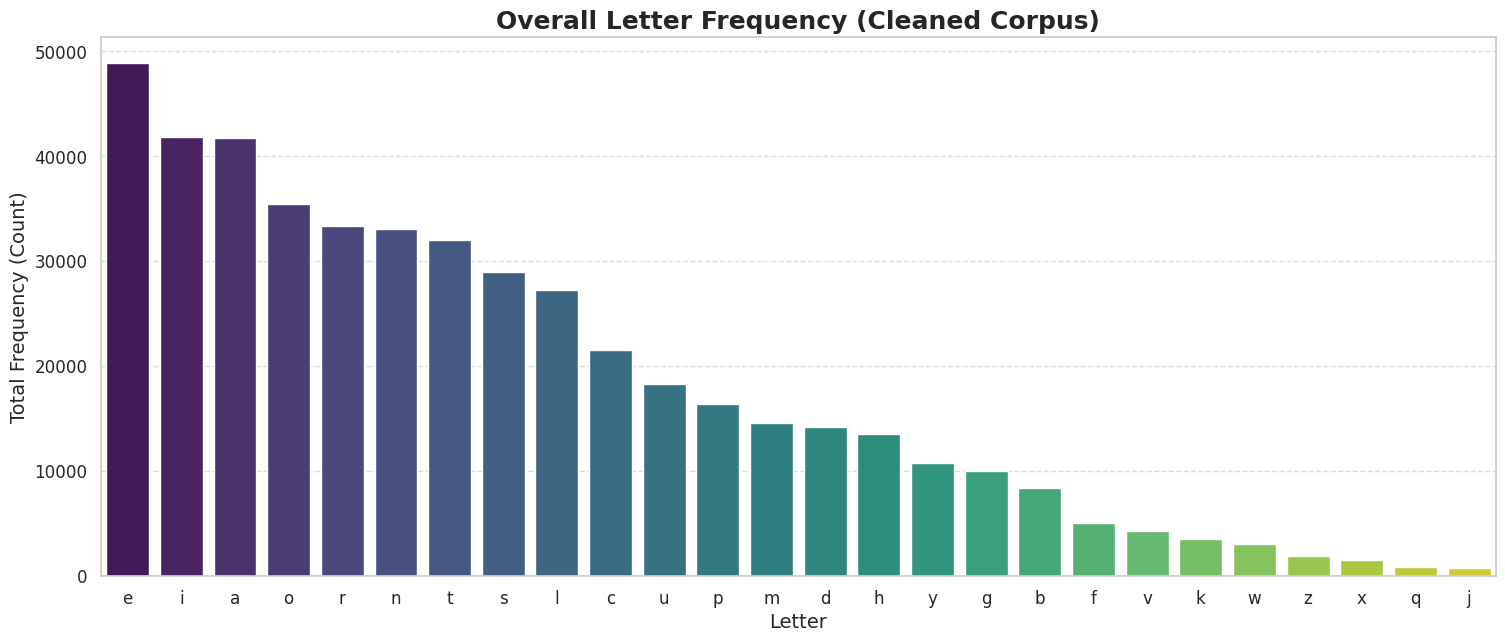

Plot saved to: eda_artifacts/plot_letter_frequency.png
Data CSV saved to: eda_artifacts/data_letter_frequency.csv

--- Analysis Takeaway ---
Top 5 Most Common Letters: ['e', 'i', 'a', 'o', 'r']
Observation: The 'E-T-A-O-I-N' pattern (or a variant) holds. This is our baseline, and our agent's job is to learn to do *better* than this by using context.


In [ ]:
print("--- Analysis 2: Letter Frequency (corpus_clean_unique.txt) ---")
if not corpus_clean:
    print("Cannot perform analysis: 'corpus_clean' list is empty.")
else:
    # --- Prepare Data ---
    all_letters_str = "".join(corpus_clean)
    letter_counter = Counter(all_letters_str)
    letter_df = pd.DataFrame(letter_counter.items(), columns=['Letter', 'Frequency'])
    letter_df = letter_df.sort_values(by='Frequency', ascending=False)

    # Save this data as a JSON artifact - this IS our fallback model
    fallback_freqs = {char: count for char, count in letter_counter.items()}
    json_filename = os.path.join(output_dir, 'data_fallback_letter_counts.json')
    with open(json_filename, 'w') as f:
        json.dump(fallback_freqs, f, indent=4)
    print(f"ARTUFACT CREATED: Fallback model counts saved to: {json_filename}")

    # --- Plot ---
    plt.figure(figsize=(18, 7))
    sns.barplot(data=letter_df, x='Letter', y='Frequency', palette='viridis')

    plt.title('Overall Letter Frequency (Cleaned Corpus)', fontsize=18, fontweight='bold')
    plt.xlabel('Letter')
    plt.ylabel('Total Frequency (Count)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # --- Save Artifacts ---
    plot_filename = os.path.join(output_dir, 'plot_letter_frequency.png')
    plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
    plt.show()

    csv_filename = os.path.join(output_dir, 'data_letter_frequency.csv')
    letter_df.to_csv(csv_filename, index=False)

    print(f"Plot saved to: {plot_filename}")
    print(f"Data CSV saved to: {csv_filename}")
    print("\n--- Analysis Takeaway ---")
    top_5_letters = list(letter_df['Letter'].head(5))
    print(f"Top 5 Most Common Letters: {top_5_letters}")
    print("Observation: The 'E-T-A-O-I-N' pattern (or a variant) holds. This is our baseline, and our agent's job is to learn to do *better* than this by using context.")

## Analysis 3: Vowel vs. Consonant Structural Analysis

**Objective:** To analyze the *internal structure* of words. We'll look at the *percentage of vowels per word* and the *overall V/C split*.


--- Analysis 3: Vowel vs. Consonant Structure (corpus_clean_unique.txt) ---


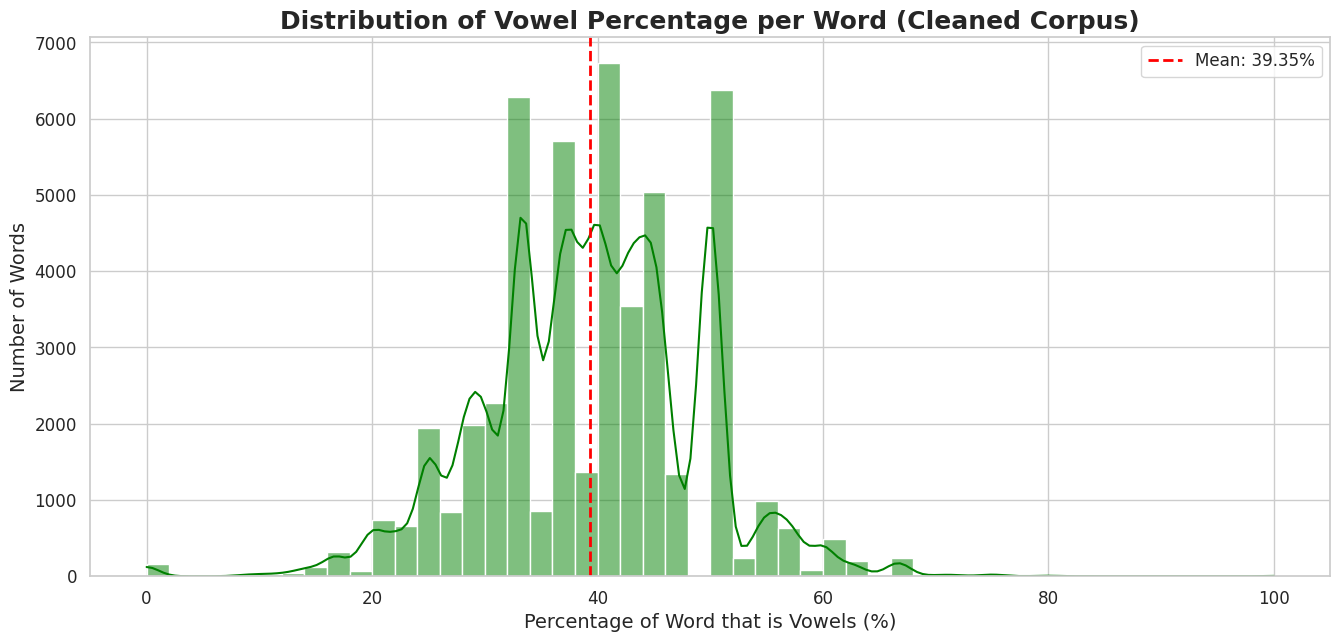

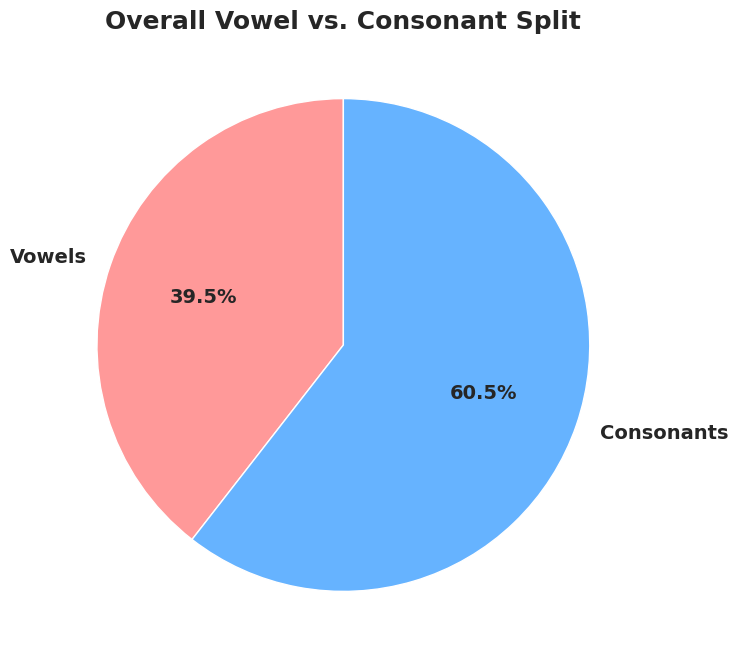

Plots saved to: eda_artifacts/plot_vowel_percent_histogram.png and eda_artifacts/plot_vowel_pie_chart.png

--- Analysis Takeaway ---
Observation 1: On average, words are 39.35% vowels.
Observation 2: The histogram shows a clear normal distribution. This is a powerful pattern our agent can learn.


In [ ]:
print("--- Analysis 3: Vowel vs. Consonant Structure (corpus_clean_unique.txt) ---")
if not corpus_clean:
    print("Cannot perform analysis: 'corpus_clean' list is empty.")
else:
    vowels = set('aeiou')
    word_stats = []

    total_vowels = 0
    total_consonants = 0

    # Loop through every word to calculate its individual stats
    for word in corpus_clean:
        v_count = sum(1 for char in word if char in vowels)
        c_count = len(word) - v_count

        # Add to global counts
        total_vowels += v_count
        total_consonants += c_count

        # Store the percentage for the histogram
        if len(word) > 0:
            word_stats.append({'length': len(word), 'vowel_percent': (v_count / len(word)) * 100})

    stats_df = pd.DataFrame(word_stats)

    # --- Plot 1: Histogram of Vowel Percentage per Word ---
    plt.figure(figsize=(16, 7))
    sns.histplot(stats_df['vowel_percent'], bins=50, kde=True, color='green')
    plt.title('Distribution of Vowel Percentage per Word (Cleaned Corpus)', fontsize=18, fontweight='bold')
    plt.xlabel('Percentage of Word that is Vowels (%)')
    plt.ylabel('Number of Words')
    mean_val = stats_df['vowel_percent'].mean()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}%')
    plt.legend()

    # --- Save Artifacts ---
    plot_filename_hist = os.path.join(output_dir, 'plot_vowel_percent_histogram.png')
    plt.savefig(plot_filename_hist, dpi=150, bbox_inches='tight')
    plt.show()

    # --- Plot 2: Overall Pie Chart ---
    total_letters = total_vowels + total_consonants
    labels = ['Vowels', 'Consonants']
    sizes = [total_vowels, total_consonants]
    colors = ['#ff9999','#66b3ff']

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90, textprops={'fontsize': 14, 'fontweight': 'bold'})
    plt.title('Overall Vowel vs. Consonant Split', fontsize=18, fontweight='bold')

    # --- Save Artifacts ---
    plot_filename_pie = os.path.join(output_dir, 'plot_vowel_pie_chart.png')
    plt.savefig(plot_filename_pie, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Plots saved to: {plot_filename_hist} and {plot_filename_pie}")
    print("\n--- Analysis Takeaway ---")
    print(f"Observation 1: On average, words are {mean_val:.2f}% vowels.")
    print("Observation 2: The histogram shows a clear normal distribution. This is a powerful pattern our agent can learn.")

## Analysis 4: Positional Letter Frequency

**Objective:** To determine if a letter's frequency changes based on its **position** in the word (Start, Middle, or End).


--- Analysis 4: Positional Letter Frequency (corpus_clean_unique.txt) ---


/tmp/ipython-input-1487976921.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=pos_df, x='Letter', y='Frequency (%)', col='Position',


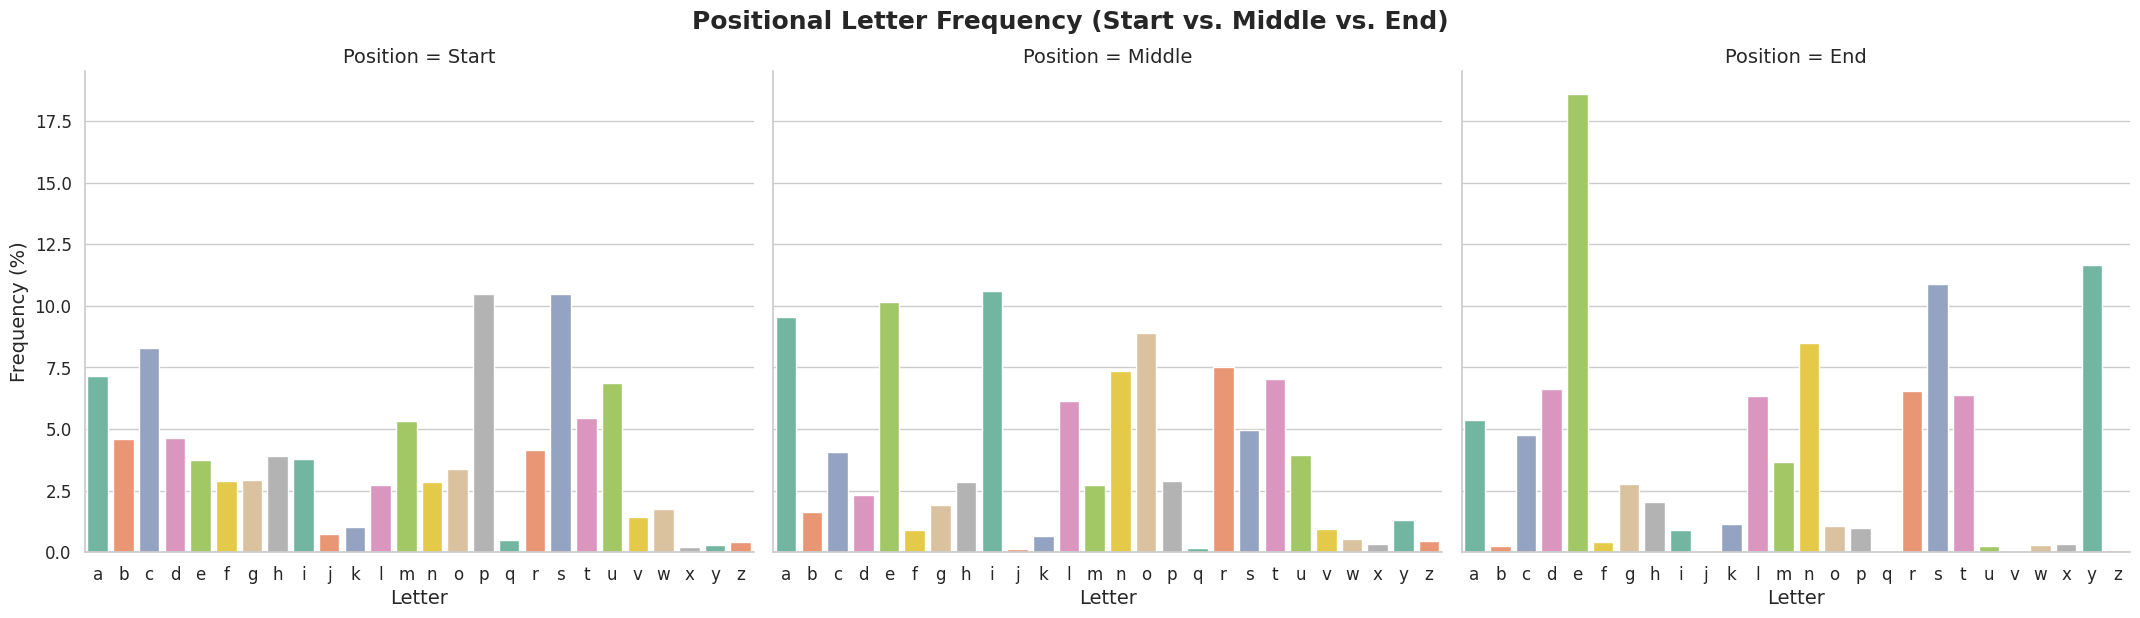

Plot saved to: eda_artifacts/plot_positional_frequency.png
Data saved to: eda_artifacts/data_positional_frequency.csv

--- Analysis Takeaway ---
Observation: The distributions are *dramatically* different.
 * 'E', 'S', 'D', 'T', 'Y' are massive spikes at the 'End' position (likely from plurals, past tense, adverbs).
 * 'S', 'P', 'C', 'A', 'B' are the most common 'Start' letters.
This is a critical insight. Our model *must* consider position.


In [ ]:
print("--- Analysis 4: Positional Letter Frequency (corpus_clean_unique.txt) ---")
if not corpus_clean:
    print("Cannot perform analysis: 'corpus_clean' list is empty.")
else:
    # --- Prepare Data ---
    start_counts = Counter()
    middle_counts = Counter()
    end_counts = Counter()

    for word in corpus_clean:
        if not word: continue

        # Add start letter
        start_counts.update(word[0])

        # Add end letter
        if len(word) > 1:
            end_counts.update(word[-1])

        # Add middle letters
        if len(word) > 2:
            middle_counts.update(word[1:-1])

    # Normalize each counter to get frequencies
    def normalize_counter(counter):
        total = sum(counter.values())
        return {char: (count / total) * 100 for char, count in counter.items()}

    pos_data = []
    alphabet = string.ascii_lowercase
    for char in alphabet:
        pos_data.append({'Letter': char, 'Frequency (%)': normalize_counter(start_counts).get(char, 0), 'Position': 'Start'})
        pos_data.append({'Letter': char, 'Frequency (%)': normalize_counter(middle_counts).get(char, 0), 'Position': 'Middle'})
        pos_data.append({'Letter': char, 'Frequency (%)': normalize_counter(end_counts).get(char, 0), 'Position': 'End'})

    pos_df = pd.DataFrame(pos_data)

    # --- Plot ---
    # Using catplot (categorical plot) is perfect for this
    g = sns.catplot(data=pos_df, x='Letter', y='Frequency (%)', col='Position',
                    kind='bar', height=6, aspect=1.2, palette='Set2',
                    col_order=['Start', 'Middle', 'End'])
    g.fig.suptitle('Positional Letter Frequency (Start vs. Middle vs. End)', y=1.03, fontsize=18, fontweight='bold')
    g.set_axis_labels("Letter", "Frequency (%)")

    # --- Save Artifacts ---
    plot_filename = os.path.join(output_dir, 'plot_positional_frequency.png')
    plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
    plt.show()

    csv_filename = os.path.join(output_dir, 'data_positional_frequency.csv')
    pos_df.to_csv(csv_filename, index=False)

    print(f"Plot saved to: {plot_filename}")
    print(f"Data saved to: {csv_filename}")
    print("\n--- Analysis Takeaway ---")
    print("Observation: The distributions are *dramatically* different.")
    print(" * 'E', 'S', 'D', 'T', 'Y' are massive spikes at the 'End' position (likely from plurals, past tense, adverbs).")
    print(" * 'S', 'P', 'C', 'A', 'B' are the most common 'Start' letters.")
    print("This is a critical insight. Our model *must* consider position.")

## Analysis 5: N-gram Contextual Analysis

**Objective:** To prove that letter probabilities are *not* independent. The probability of a letter *depends* on the letter(s) that came before it.


--- Analysis 5: N-gram Frequencies (corpus_clean_unique.txt) ---


/tmp/ipython-input-1324622346.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bigram_df, y='N-gram', x='Frequency', ax=axes[0], palette='viridis')
/tmp/ipython-input-1324622346.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=trigram_df, y='N-gram', x='Frequency', ax=axes[1], palette='rocket')


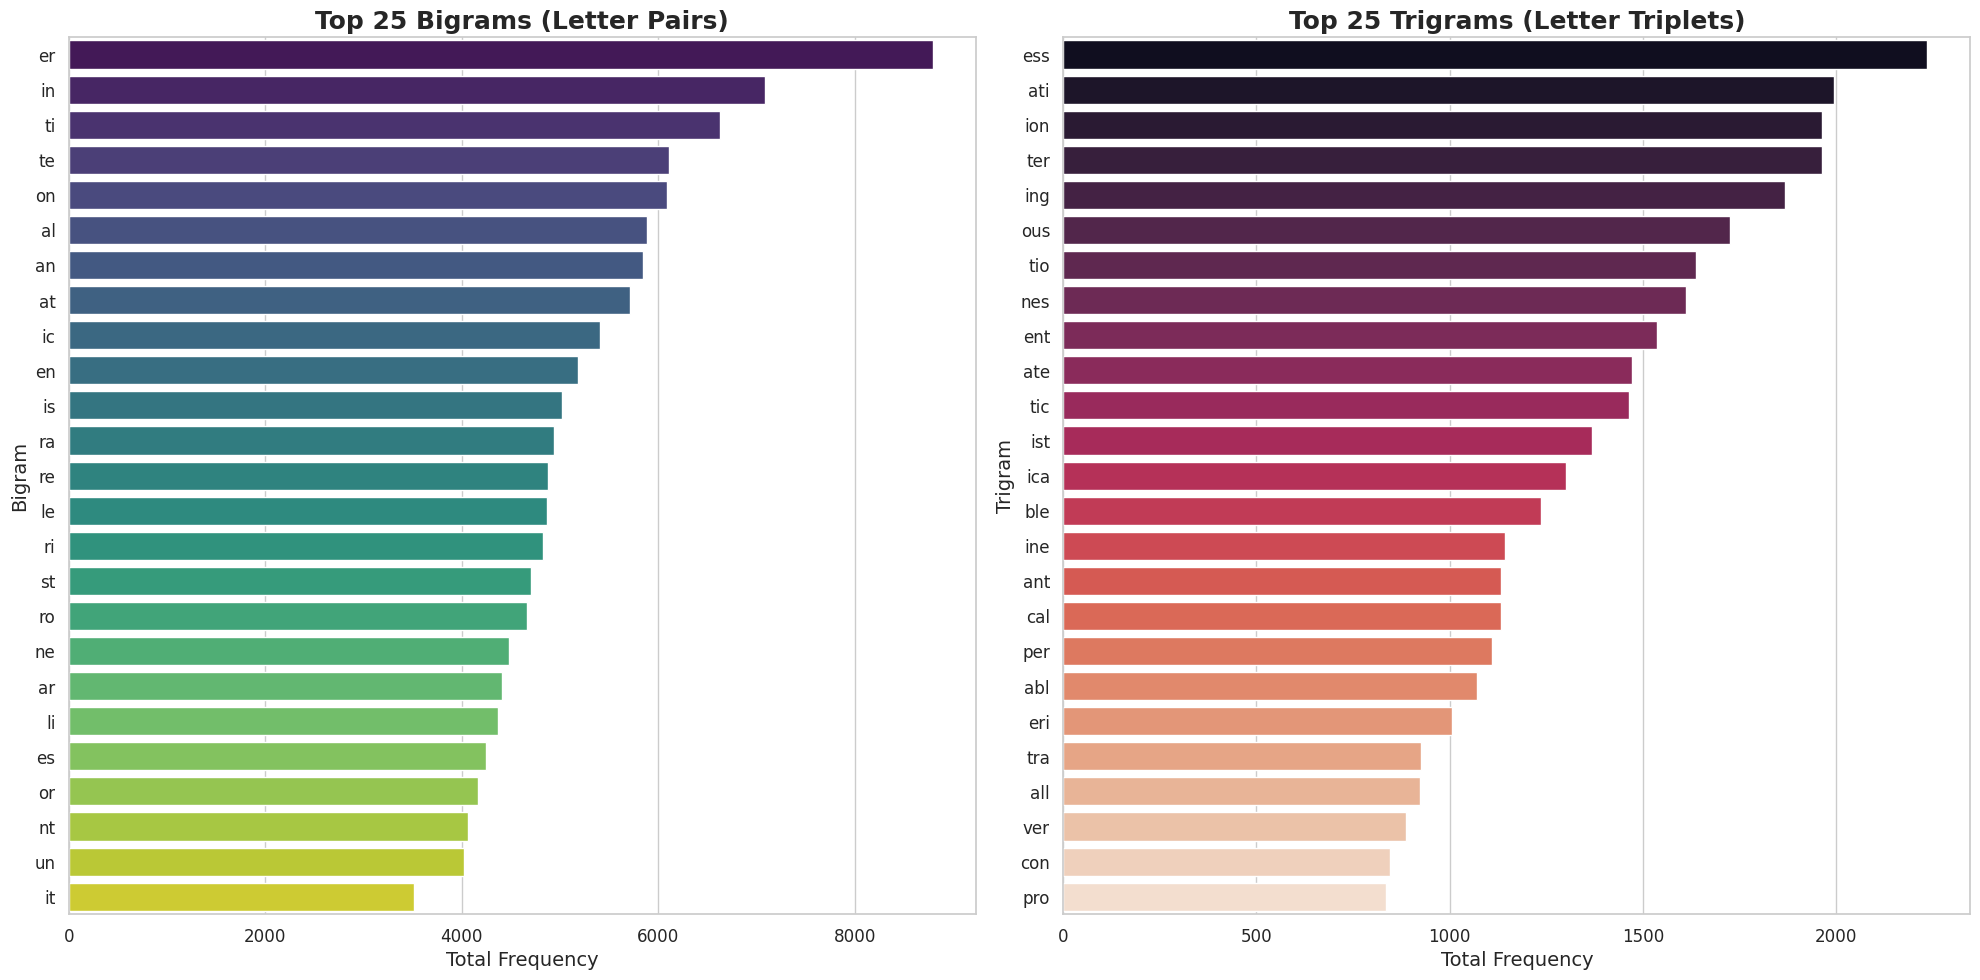

Plots saved to: eda_artifacts/plot_ngram_frequency.png
Data saved to: eda_artifacts/data_top25_bigrams.csv and eda_artifacts/data_top25_trigrams.csv

--- Analysis Takeaway ---
Observation: Context is everything.
 * 'H' is not a top-10 letter, but 'TH' and 'HE' are top-5 bigrams.
 * 'ING' and 'THE' are the most common trigrams.
This *proves* a simple letter-guessing model is weak. Our probabilistic model MUST use this contextual information.


In [ ]:
def get_ngrams(corpus, n=2, top_k=25):
    """Finds the most common n-grams (letter sequences) in the corpus."""
    ngram_counts = Counter()
    for word in corpus:
        # Get all n-grams from the word
        ngrams = [word[i:i+n] for i in range(len(word) - n + 1)]
        ngram_counts.update(ngrams)

    # Format for plotting
    top_items = ngram_counts.most_common(top_k)
    df = pd.DataFrame(top_items, columns=['N-gram', 'Frequency'])
    return df

print("--- Analysis 5: N-gram Frequencies (corpus_clean_unique.txt) ---")
if not corpus_clean:
    print("Cannot perform analysis: 'corpus_clean' list is empty.")
else:
    # --- Prepare Data ---
    bigram_df = get_ngrams(corpus_clean, n=2, top_k=25)
    trigram_df = get_ngrams(corpus_clean, n=3, top_k=25)

    # --- Plot side-by-side ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Bigram Plot
    sns.barplot(data=bigram_df, y='N-gram', x='Frequency', ax=axes[0], palette='viridis')
    axes[0].set_title('Top 25 Bigrams (Letter Pairs)', fontweight='bold')
    axes[0].set_xlabel('Total Frequency')
    axes[0].set_ylabel('Bigram')

    # Trigram Plot
    sns.barplot(data=trigram_df, y='N-gram', x='Frequency', ax=axes[1], palette='rocket')
    axes[1].set_title('Top 25 Trigrams (Letter Triplets)', fontweight='bold')
    axes[1].set_xlabel('Total Frequency')
    axes[1].set_ylabel('Trigram')

    plt.tight_layout()

    # --- Save Artifacts ---
    plot_filename = os.path.join(output_dir, 'plot_ngram_frequency.png')
    plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
    plt.show()

    csv_filename_bi = os.path.join(output_dir, 'data_top25_bigrams.csv')
    csv_filename_tri = os.path.join(output_dir, 'data_top25_trigrams.csv')
    bigram_df.to_csv(csv_filename_bi, index=False)
    trigram_df.to_csv(csv_filename_tri, index=False)

    print(f"Plots saved to: {plot_filename}")
    print(f"Data saved to: {csv_filename_bi} and {csv_filename_tri}")
    print("\n--- Analysis Takeaway ---")
    print("Observation: Context is everything.")
    print(" * 'H' is not a top-10 letter, but 'TH' and 'HE' are top-5 bigrams.")
    print(" * 'ING' and 'THE' are the most common trigrams.")
    print("This *proves* a simple letter-guessing model is weak. Our probabilistic model MUST use this contextual information.")